In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns

import math, time, random, datetime

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier



In [2]:
df = pd.read_csv("salary.csv")

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Strip extra space charachter added to inputs

df.workclass = df.workclass.str.strip()
df.education = df.education.str.strip()
df["marital-status"] = df["marital-status"].str.strip()
df.occupation = df.occupation.str.strip()
df.relationship = df.relationship.str.strip()
df.race = df.race.str.strip()
df["native-country"] = df["native-country"].str.strip()
df.salary = df.salary.str.strip()


In [6]:
da = df.copy()

# Drop "education" because it is encoded in the education_num column
da.drop(columns=["education"], inplace=True)

# Drop "relationship" because the information it contains can be infered from "sex" and "marital-status"
da.drop(columns=["relationship"], inplace=True)

# Drop "fnlwgt" for simplicity
da.drop(columns=["fnlwgt"], inplace=True)


In [7]:
# Most observations have zero capital_gain and/or capital_loss
da.drop(columns=["capital-gain"], inplace=True)
da.drop(columns=["capital-loss"], inplace=True)

# Similarly, there native_country displays high skewness as most observations are from United States
da.drop(columns=["native-country"], inplace=True)

In [8]:
da.head()

,age,workclass,education-num,marital-status,occupation,race,sex,hours-per-week,salary
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,40,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,13,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,40,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,40,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,40,<=50K


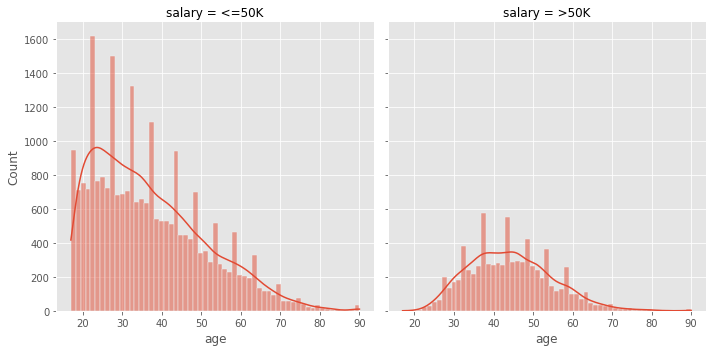

In [9]:
sns.displot(data=da, x="age", col="salary", kde=True)


It is noticed that majority of the observations make less than $50,000 a year. For those who make over $50,000 annually, they are mainly in midcareer. 

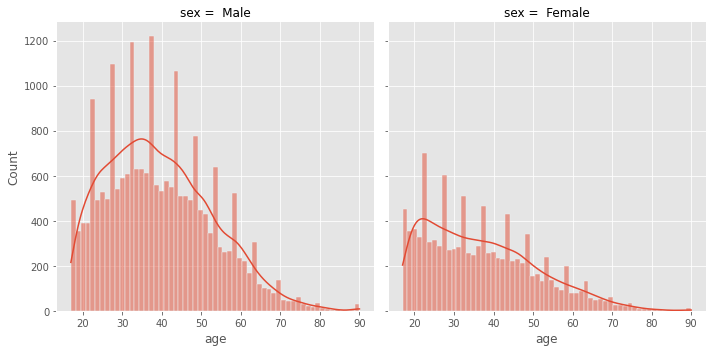

In [10]:
sns.displot(data=da, x="age", col="sex", kde=True)

Females are underrepresented. This could be possibly caused by census bias.

## "WORKCLASS" variable:


In [11]:
# The variable workclass stands for the industry in which the responding unit is employed.

da.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [12]:
# We combine "Never-worked" and "Without-pay" and "?" in a new groupe called "Other/Unknown"

da.loc[(da.workclass == "?") | (da.workclass == "Never-worked") | (da.workclass == "Without-pay"), "workclass"] = "Other/Unknown" 

In [13]:
# We combine all the goverment workers in one category called "Goverment"

da.loc[(da.workclass == "Local-gov") | (da.workclass == "State-gov") | (da.workclass == "Federal-gov"), "workclass"] = "Goverment"

In [14]:
# We combine all the self-employed into one new category called "Self-Employed"

da.loc[(da.workclass == "Self-emp-inc") | (da.workclass == "Self-emp-not-inc"), "workclass"] = "Self-Employed"

In [15]:
da.workclass.value_counts()

Private          22696
Goverment         4351
Self-Employed     3657
Other/Unknown     1857
Name: workclass, dtype: int64

In [16]:
# Workclass by income group

ClassInc = da[['workclass', 'salary']].value_counts().to_frame().reset_index()

ClassInc.rename(columns= {0 : "counter"}, inplace=True)

ClassInc

,workclass,salary,counter
0,Private,<=50K,17733
1,Private,>50K,4963
2,Goverment,<=50K,3010
3,Self-Employed,<=50K,2311
4,Other/Unknown,<=50K,1666
5,Self-Employed,>50K,1346
6,Goverment,>50K,1341
7,Other/Unknown,>50K,191


In [17]:
# Compute the percentage of each income group depending on the workclass

ClassInc["total"] = 0
ClassInc["percentage"] = 0

for i in ClassInc.index:
    ClassInc.at[i ,"total"] = da.workclass.value_counts().loc[ClassInc.iloc[i].workclass]
    ClassInc.at[i ,"percentage"] = '{:.2f}%'.format((ClassInc.at[i , "counter"] / ClassInc.at[i , "total"])*100)

# Creating two seprate dataframes depending on the salary to use in plotting

lowInc = ClassInc.loc[ClassInc.salary == "<=50K"]
highInc = ClassInc.loc[ClassInc.salary != "<=50K"]


lowInc = lowInc.sort_values(by="total", ascending=False)   
highInc = highInc.sort_values(by="total", ascending=False)   

ClassInc

,workclass,salary,counter,total,percentage
0,Private,<=50K,17733,22696,78.13%
1,Private,>50K,4963,22696,21.87%
2,Goverment,<=50K,3010,4351,69.18%
3,Self-Employed,<=50K,2311,3657,63.19%
4,Other/Unknown,<=50K,1666,1857,89.71%
5,Self-Employed,>50K,1346,3657,36.81%
6,Goverment,>50K,1341,4351,30.82%
7,Other/Unknown,>50K,191,1857,10.29%


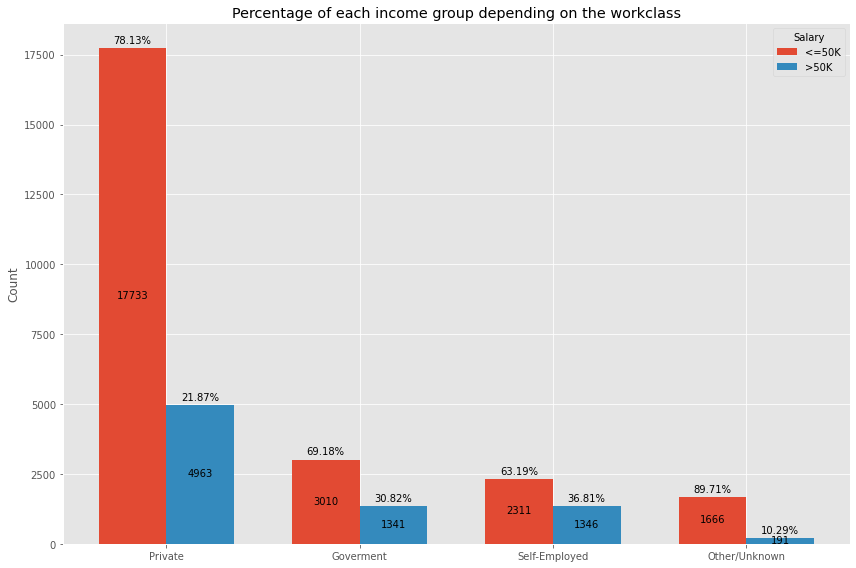

In [18]:
from matplotlib.pyplot import title


x = np.arange(len(lowInc.workclass))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, lowInc.counter, width, label='<=50K')
rects2 = ax.bar(x + width/2, highInc.counter, width, label='>50K')

ax.set_ylabel('Count')
ax.set_title('Percentage of each income group depending on the workclass')
ax.set_xticks(x, lowInc.workclass)
ax.legend(title="Salary")

ax.bar_label(rects1, label_type='center', padding=1)
ax.bar_label(rects1, labels=lowInc.percentage, padding=3)
ax.bar_label(rects2, label_type='center', padding=1)
ax.bar_label(rects2, labels=highInc.percentage, padding=3)

fig.tight_layout()

plt.show()

Those who are self employed have the highest tendency of making greater than $50,000 a year.

## "EDUCATION_NUM" variable


In [19]:
# As mentioned earlier, the column "education" in df is encoded in the column "education-num" as follows

df[['education-num','education']].drop_duplicates().sort_values(by="education-num")

,education-num,education
224,1,Preschool
160,2,1st-4th
56,3,5th-6th
15,4,7th-8th
6,5,9th
77,6,10th
3,7,11th
415,8,12th
2,9,HS-grad
10,10,Some-college


In [20]:
# Education-num by income group

eduInc = da[['education-num','salary']].value_counts().to_frame().reset_index()

eduInc.rename(columns= {0 : "counter"}, inplace=True) #Renaming column 0 


# Since there is no one that has "education-num":0 we add it for plotting purposes

new_row = pd.DataFrame({'education-num':1, 'salary':'>50K', 'counter':0}, index=[1]) 
eduInc = pd.concat([new_row,eduInc.loc[:]]).reset_index(drop=True)

eduInc = eduInc.sort_values(by=["education-num","salary"])

eduInc.reset_index(inplace=True, drop=True)

eduInc

,education-num,salary,counter
0,1,<=50K,51
1,1,>50K,0
2,2,<=50K,162
3,2,>50K,6
4,3,<=50K,317
5,3,>50K,16
6,4,<=50K,606
7,4,>50K,40
8,5,<=50K,487
9,5,>50K,27


In [21]:
# Compute the percentage of each income group depending on the education

eduInc["total"] = 0
eduInc["percentage"] = 0

for i in eduInc.index:
    eduInc.at[i ,"total"] = da['education-num'].value_counts().loc[eduInc.iloc[i]['education-num']]
    eduInc.at[i ,"percentage"] = '{:.2f}%'.format((eduInc.at[i , "counter"] / eduInc.at[i , "total"])*100)

eduInc

,education-num,salary,counter,total,percentage
0,1,<=50K,51,51,100.00%
1,1,>50K,0,51,0.00%
2,2,<=50K,162,168,96.43%
3,2,>50K,6,168,3.57%
4,3,<=50K,317,333,95.20%
5,3,>50K,16,333,4.80%
6,4,<=50K,606,646,93.81%
7,4,>50K,40,646,6.19%
8,5,<=50K,487,514,94.75%
9,5,>50K,27,514,5.25%


In [22]:
lowEduInc = eduInc.loc[eduInc["salary"] == "<=50K"]
highEduInc = eduInc.loc[eduInc["salary"] != "<=50K"]

lowEduInc

,education-num,salary,counter,total,percentage
0,1,<=50K,51,51,100.00%
2,2,<=50K,162,168,96.43%
4,3,<=50K,317,333,95.20%
6,4,<=50K,606,646,93.81%
8,5,<=50K,487,514,94.75%
10,6,<=50K,871,933,93.35%
12,7,<=50K,1115,1175,94.89%
14,8,<=50K,400,433,92.38%
16,9,<=50K,8826,10501,84.05%
18,10,<=50K,5904,7291,80.98%


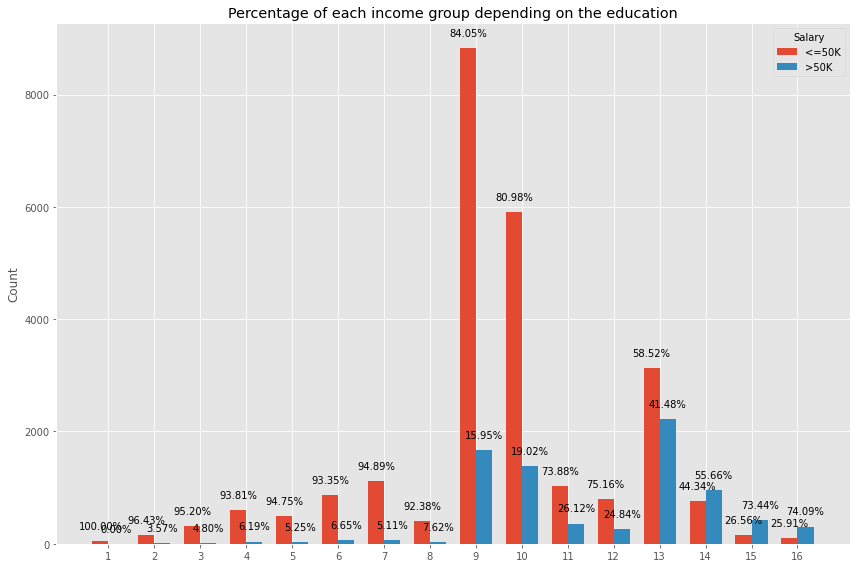

In [52]:
x = np.arange(len(lowEduInc["education-num"]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, lowEduInc.counter, width, label='<=50K')
rects2 = ax.bar(x + width/2, highEduInc.counter, width, label='>50K')

ax.set_ylabel('Count')
ax.set_title('Percentage of each income group depending on the education')
ax.set_xticks(x, lowEduInc["education-num"])
ax.legend(title="Salary")

ax.bar_label(rects1, labels=lowEduInc.percentage, padding=10)
ax.bar_label(rects2, labels=highEduInc.percentage, padding=10)

fig.tight_layout()

plt.show()

We notice that the in group proportion of making greater than 50,000 dollars a year increase as the years of education increases. For those who don’t have any forms of college education (less than or equal to 8 years of education), less than 10% have an annual income of greater than 50,000 dollars. While for those with doctorate degrees, nearly 75% makes greater than 50,000 dollars a year!

## "OCCUPATION" variable

In [24]:
da.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

For simplicity of the model, occupation is also blocked into several groups, namely "Blue-Collar", "Professional", "Sales", "Service", and "White-Collar". Because of the small number of people who are "Armed-Forces" members, they are combined with "?" to form an "Unknown/Other" group.

In [25]:
da.loc[da.occupation == "Adm-clerical", "occupation"] = "White-Collar"
da.loc[da.occupation == "Exec-managerial", "occupation"] = "White-Collar"

da.loc[da.occupation == "Craft-repair", "occupation"] = "Blue-Collar"
da.loc[da.occupation == "Farming-fishing", "occupation"] = "Blue-Collar"
da.loc[da.occupation == "Handlers-cleaners", "occupation"] = "Blue-Collar"
da.loc[da.occupation == "Machine-op-inspct", "occupation"] = "Blue-Collar"
da.loc[da.occupation == "Transport-moving", "occupation"] = "Blue-Collar"

da.loc[da.occupation == "Other-service", "occupation"] = "Service"
da.loc[da.occupation == "Priv-house-serv", "occupation"] = "Service"
da.loc[da.occupation == "Protective-serv", "occupation"] = "Service"
da.loc[da.occupation == "Tech-support", "occupation"] = "Service"

da.loc[da.occupation == "Prof-specialty", "occupation"] = "Professional"

da.loc[da.occupation == "?", "occupation"] = "Unknown/Other"
da.loc[da.occupation == "Armed-Forces", "occupation"] = "Unknown/Other"

In [26]:
occInc = da[["occupation","salary"]].value_counts().to_frame().reset_index()

occInc.rename(columns= {0 : "counter"}, inplace=True) #Renaming column 0 

occInc

,occupation,salary,counter
0,Blue-Collar,<=50K,8362
1,White-Collar,<=50K,5361
2,Service,<=50K,4389
3,Sales,<=50K,2667
4,White-Collar,>50K,2475
5,Professional,<=50K,2281
6,Professional,>50K,1859
7,Blue-Collar,>50K,1700
8,Unknown/Other,<=50K,1660
9,Sales,>50K,983


In [27]:
# Compute the percentage of each income group depending on the occupation

occInc["total"] = 0
occInc["percentage"] = 0

for i in occInc.index:
    occInc.at[i ,"total"] = da.occupation.value_counts().loc[occInc.iloc[i].occupation]
    occInc.at[i ,"percentage"] = '{:.2f}%'.format((occInc.at[i , "counter"] / occInc.at[i , "total"])*100)

# Creating two seprate dataframes depending on the salary to use in plotting

occlowInc = occInc.loc[occInc.salary == "<=50K"]
occhighInc = occInc.loc[occInc.salary != "<=50K"]


occlowInc = occlowInc.sort_values(by="total", ascending=False)   
occhighInc = occhighInc.sort_values(by="total", ascending=False)  

occhighInc


,occupation,salary,counter,total,percentage
7,Blue-Collar,>50K,1700,10062,16.90%
4,White-Collar,>50K,2475,7836,31.58%
10,Service,>50K,632,5021,12.59%
6,Professional,>50K,1859,4140,44.90%
9,Sales,>50K,983,3650,26.93%
11,Unknown/Other,>50K,192,1852,10.37%


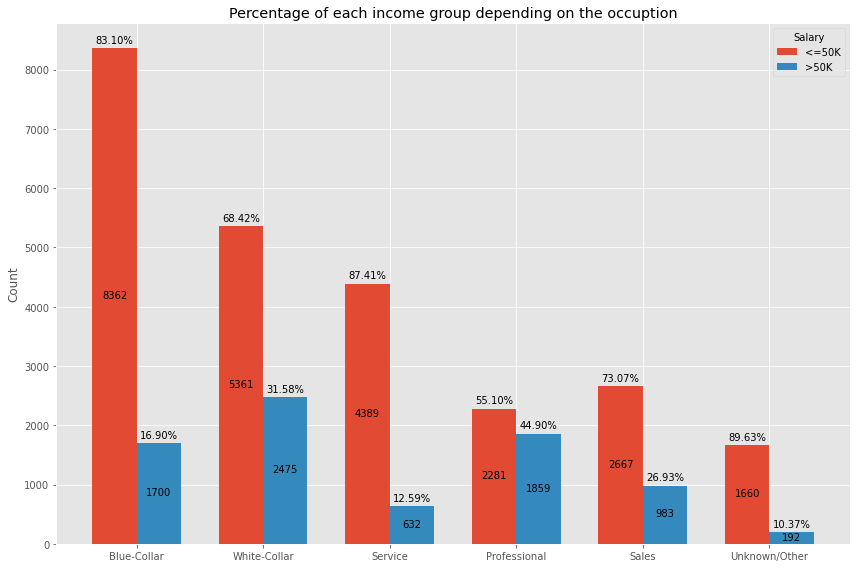

In [28]:
x = np.arange(len(occlowInc.occupation))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, occlowInc.counter, width, label='<=50K')
rects2 = ax.bar(x + width/2, occhighInc.counter, width, label='>50K')

ax.set_ylabel('Count')
ax.set_title('Percentage of each income group depending on the occuption')
ax.set_xticks(x, occlowInc.occupation)
ax.legend(title="Salary")

ax.bar_label(rects1, label_type='center', padding=1)
ax.bar_label(rects1, labels=occlowInc.percentage, padding=3)
ax.bar_label(rects2, label_type='center', padding=1)
ax.bar_label(rects2, labels=occhighInc.percentage, padding=3)

fig.tight_layout()

plt.show()

It is noticed that income varies greatly across different occupations. Nearly half of Professional occupation makes greater than $50,000 a year, while that percentage is only 13% for Service occupation.

##MARITAL-STATUS Variable

In [29]:
da["marital-status"].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

In [30]:
da.loc[da["marital-status"] == "Married-AF-spouse", "marital-status"] = "Married"
da.loc[da["marital-status"] == "Married-civ-spouse", "marital-status"] = "Married"
da.loc[da["marital-status"] == "Married-spouse-absent", "marital-status"] = "Married"

da.loc[da["marital-status"] == "Never-married", "marital-status"] = "Single"

In [31]:
marInc = da[["marital-status","salary"]].value_counts().to_frame().reset_index()

marInc.rename(columns= {0 : "counter"}, inplace=True) #Renaming column 0 

marInc

,marital-status,salary,counter
0,Single,<=50K,10192
1,Married,<=50K,8681
2,Married,>50K,6736
3,Divorced,<=50K,3980
4,Separated,<=50K,959
5,Widowed,<=50K,908
6,Single,>50K,491
7,Divorced,>50K,463
8,Widowed,>50K,85
9,Separated,>50K,66


In [32]:
# Compute the percentage of each income group depending on the "marital-status"

marInc["total"] = 0
marInc["percentage"] = 0

for i in marInc.index:
    marInc.at[i ,"total"] = da["marital-status"].value_counts().loc[marInc.iloc[i]["marital-status"]]
    marInc.at[i ,"percentage"] = '{:.2f}%'.format((marInc.at[i , "counter"] / marInc.at[i , "total"])*100)

# Creating two seprate dataframes depending on the salary to use in plotting

marlowInc = marInc.loc[marInc.salary == "<=50K"]
marhighInc = marInc.loc[marInc.salary != "<=50K"]


marlowInc = marlowInc.sort_values(by="total", ascending=False)   
marhighInc = marhighInc.sort_values(by="total", ascending=False)  

marhighInc

,marital-status,salary,counter,total,percentage
2,Married,>50K,6736,15417,43.69%
6,Single,>50K,491,10683,4.60%
7,Divorced,>50K,463,4443,10.42%
9,Separated,>50K,66,1025,6.44%
8,Widowed,>50K,85,993,8.56%


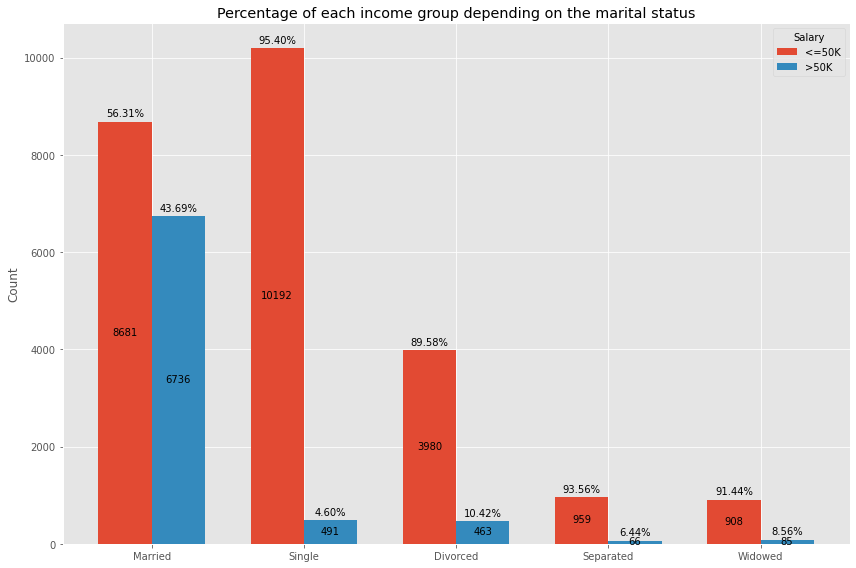

In [33]:
x = np.arange(len(marlowInc["marital-status"]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, marlowInc.counter, width, label='<=50K')
rects2 = ax.bar(x + width/2, marhighInc.counter, width, label='>50K')

ax.set_ylabel('Count')
ax.set_title('Percentage of each income group depending on the marital status')
ax.set_xticks(x, marlowInc["marital-status"])
ax.legend(title="Salary")

ax.bar_label(rects1, label_type='center', padding=1)
ax.bar_label(rects1, labels=marlowInc.percentage, padding=3)
ax.bar_label(rects2, label_type='center', padding=1)
ax.bar_label(rects2, labels=marhighInc.percentage, padding=3)

fig.tight_layout()

plt.show()

Those who are married, nearly half of them are making greater than $50,000 a year.

## RACE variable

In [34]:
da.race.value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

In [35]:
raceInc = da[["race","salary"]].value_counts().to_frame().reset_index()

raceInc.rename(columns= {0 : "counter"}, inplace=True) #Renaming column 0 

raceInc

,race,salary,counter
0,White,<=50K,20699
1,White,>50K,7117
2,Black,<=50K,2737
3,Asian-Pac-Islander,<=50K,763
4,Black,>50K,387
5,Asian-Pac-Islander,>50K,276
6,Amer-Indian-Eskimo,<=50K,275
7,Other,<=50K,246
8,Amer-Indian-Eskimo,>50K,36
9,Other,>50K,25


In [36]:
# Compute the percentage of each income group depending on the "race"

raceInc["total"] = 0
raceInc["percentage"] = 0

for i in raceInc.index:
    raceInc.at[i ,"total"] = da["race"].value_counts().loc[raceInc.iloc[i]["race"]]
    raceInc.at[i ,"percentage"] = '{:.2f}%'.format((raceInc.at[i , "counter"] / raceInc.at[i , "total"])*100)

# Creating two seprate dataframes depending on the salary to use in plotting

racelowInc = raceInc.loc[raceInc.salary == "<=50K"]
racehighInc = raceInc.loc[raceInc.salary != "<=50K"]


racelowInc = racelowInc.sort_values(by="total", ascending=False)   
racehighInc = racehighInc.sort_values(by="total", ascending=False)  

racehighInc

,race,salary,counter,total,percentage
1,White,>50K,7117,27816,25.59%
4,Black,>50K,387,3124,12.39%
5,Asian-Pac-Islander,>50K,276,1039,26.56%
8,Amer-Indian-Eskimo,>50K,36,311,11.58%
9,Other,>50K,25,271,9.23%


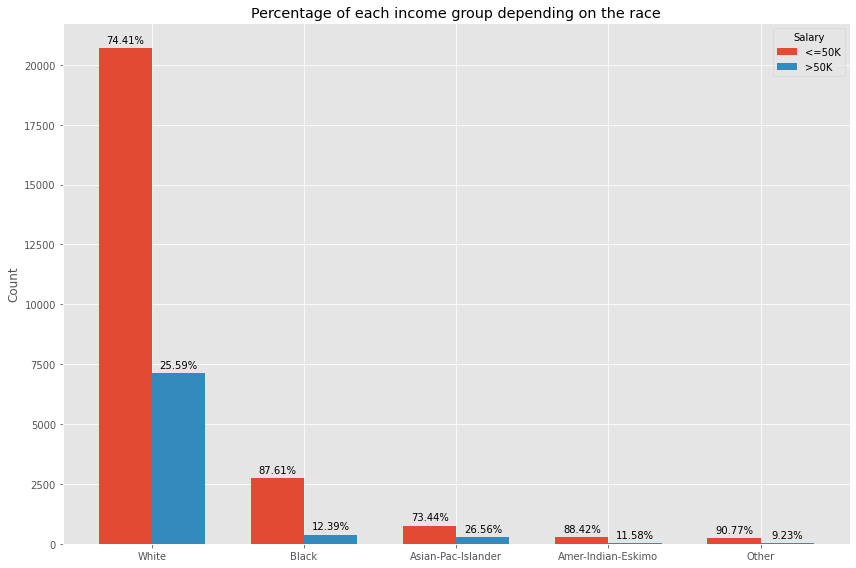

In [53]:
x = np.arange(len(racelowInc["race"]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()


rects1 = ax.bar(x - width/2, racelowInc.counter, width, label='<=50K')
rects2 = ax.bar(x + width/2, racehighInc.counter, width, label='>50K')

ax.set_ylabel('Count')
ax.set_title('Percentage of each income group depending on the race')
ax.set_xticks(x, racelowInc["race"])
ax.legend(title="Salary")


ax.bar_label(rects1, labels=racelowInc.percentage, padding=3)
ax.bar_label(rects2, labels=racehighInc.percentage, padding=3)

fig.tight_layout()

plt.show()

## Hours-per-week

<AxesSubplot:>

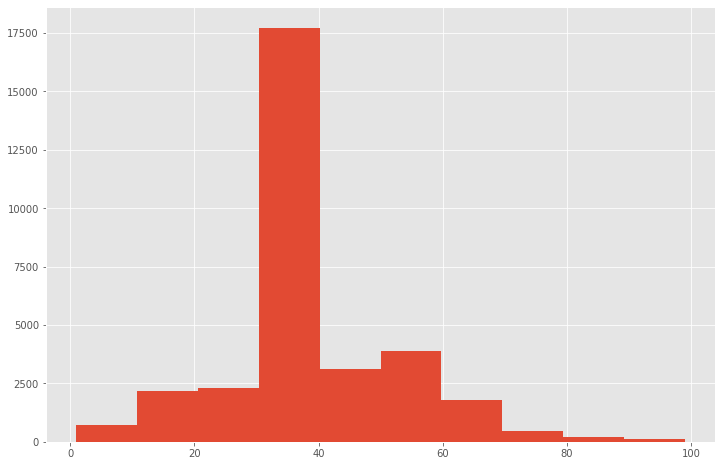

In [38]:
da["hours-per-week"].hist()

We will divide the "hours-per-week" into 4 groups:

"hours-per-week" <= 20  ---> 0 <br>
20 < "hours-per-week" <= 40 ---> 1 <br>
40 < "hours-per-week" <= 60 ---> 2 <br>
60 < "hours-per-week" ---> 3 


In [39]:
da.loc[da["hours-per-week"] <= 20, "hours-per-week"] = 0
da.loc[(20 < da["hours-per-week"]) &  (da["hours-per-week"] <= 40), "hours-per-week"] = 1
da.loc[(40 < da["hours-per-week"]) & (da["hours-per-week"] <= 60), "hours-per-week"] = 2
da.loc[60 < da["hours-per-week"] , "hours-per-week"] = 3

In [40]:
da.sample(10)

,age,workclass,education-num,marital-status,occupation,race,sex,hours-per-week,salary
22223,47,Private,9,Married,Sales,Black,Male,1,>50K
27454,35,Private,9,Married,Blue-Collar,Black,Female,1,<=50K
9301,19,Private,10,Single,Service,White,Male,1,<=50K
20953,80,Other/Unknown,9,Married,Unknown/Other,White,Male,0,<=50K
12628,27,Private,9,Single,Sales,White,Female,1,<=50K
13634,45,Private,8,Married,White-Collar,White,Male,2,<=50K
28682,47,Private,9,Divorced,Blue-Collar,White,Male,1,<=50K
18800,17,Private,6,Married,Sales,White,Female,1,<=50K
12304,55,Private,10,Married,Blue-Collar,Black,Male,1,>50K
14308,45,Private,11,Married,Blue-Collar,White,Male,3,<=50K


## Encoding Object vairables

In [41]:
df_encoded = da.copy()


le = preprocessing.LabelEncoder()

cols = ["workclass", "marital-status", "occupation", "race", "sex", "salary"]

for col in cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [42]:
df_encoded.head()

,age,workclass,education-num,marital-status,occupation,race,sex,hours-per-week,salary
0,39,0,13,3,5,4,1,1,0
1,50,3,13,1,5,4,1,0,0
2,38,2,9,0,0,4,1,1,0
3,53,2,7,1,0,2,1,1,0
4,28,2,13,1,1,2,0,1,0


## Splitting data

In [43]:
X_train = df_encoded.drop(columns="salary")
y_train = df_encoded.salary

## Training Models:

In [62]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv , model

## Logistic Regression

In [76]:
# Logistic Regression
start_time = time.time()

train_pred_log, acc_log, acc_cv_log , log_model  = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 80.64
Accuracy CV 10-Fold: 80.56
Running Time: 0:00:02.076465


## k-Nearest Neighbours

In [65]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn , knn_model = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 85.51
Accuracy CV 10-Fold: 80.27
Running Time: 0:00:03.562473


## Gaussian Naive Bayes

In [66]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian, gaussian_model = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 79.24
Accuracy CV 10-Fold: 79.21
Running Time: 0:00:00.253727


## Linear SVC

In [67]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc, linear_svc_model = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 78.87
Accuracy CV 10-Fold: 69.95
Running Time: 0:00:41.779309


## Stochastic Gradient Descent

In [68]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd , sgd_model= fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 80.72
Accuracy CV 10-Fold: 78.28
Running Time: 0:00:11.155180


## Decision Tree Classifier

In [69]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt , dt_model = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.38
Accuracy CV 10-Fold: 78.29
Running Time: 0:00:00.490609


## Gradient Boosting Trees

In [70]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt, gbt_model= fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 83.49
Accuracy CV 10-Fold: 83.23
Running Time: 0:00:10.240658


## Summarize

In [71]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'
              ],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.38
0,KNN,85.51
6,Gradient Boosting Trees,83.49
3,Stochastic Gradient Decent,80.72
1,Logistic Regression,80.64
2,Naive Bayes,79.24
4,Linear SVC,78.87


In [72]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,83.23
1,Logistic Regression,80.56
0,KNN,80.27
2,Naive Bayes,79.21
5,Decision Tree,78.29
3,Stochastic Gradient Decent,78.28
4,Linear SVC,69.95


## Feature Importance

In [73]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp 

,imp,col
5,0.002447,race
1,0.005359,workclass
6,0.024250,sex
4,0.031699,occupation
7,0.060776,hours-per-week
0,0.105715,age
2,0.316967,education-num
3,0.452786,marital-status


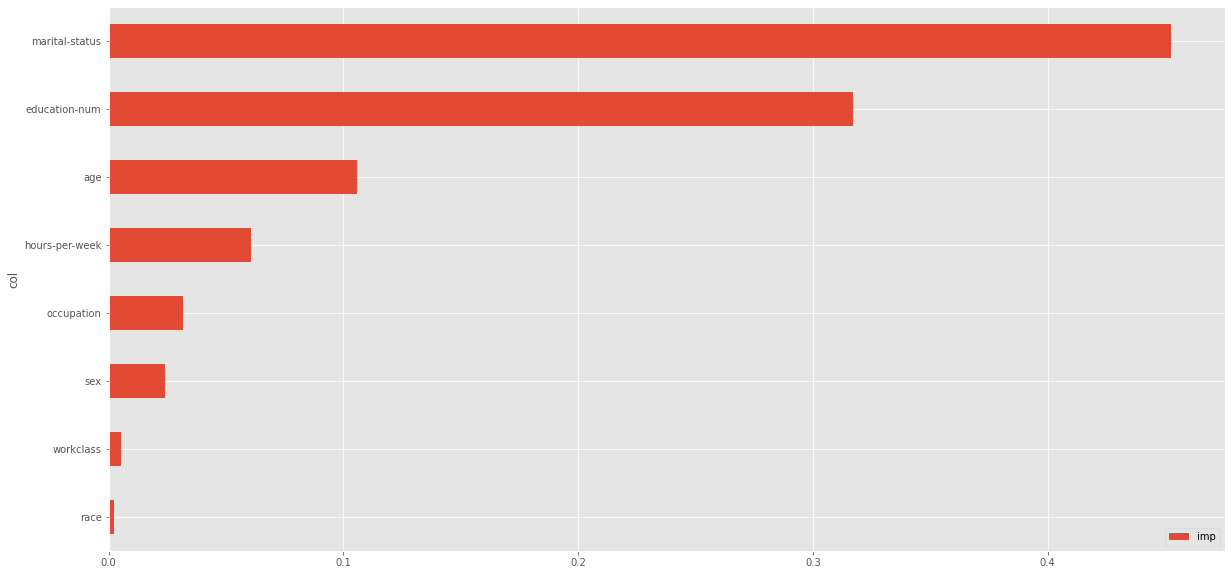

In [77]:
feature_importance(gbt_model, X_train)


Gradient Boosting Trees has the highest cross-validation accuracy. The most feature that affects its model is marital-status.